In [2]:
%load_ext autoreload
%autoreload 2
from calibrate import *
import matplotlib.pyplot as plt
import numpy as np
import skimage
import imageio

In [48]:
master_bias('/home/felix/PiCamera_DSLR_like_controller/calibration/Bias', '/home/felix/PiCamera_DSLR_like_controller/calibration/computed')
mbias = np.load('/home/felix/PiCamera_DSLR_like_controller/calibration/computed/master_bias.npy')


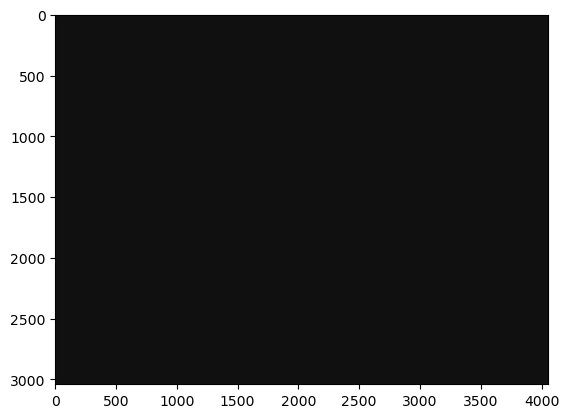

In [5]:
mbias = np.load('/home/felix/PiCamera_DSLR_like_controller/calibration/computed/master_bias.npy')
plt.imshow(cv.convertScaleAbs(mbias, alpha=(255.0/65535.0)).astype(np.uint8))

In [4]:
master_flat(img_dir='/home/felix/PiCamera_DSLR_like_controller/calibration/Flats',out_dir='/home/felix/PiCamera_DSLR_like_controller/calibration/computed', mbias='/home/felix/PiCamera_DSLR_like_controller/calibration/computed/master_bias.npy',mdark=None)
mflat = np.load('/home/felix/PiCamera_DSLR_like_controller/calibration/computed/master_flat.npy')


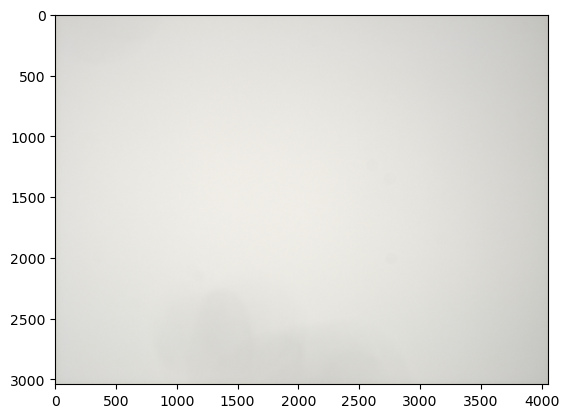

In [8]:
mflat = np.load('/home/felix/PiCamera_DSLR_like_controller/calibration/computed/master_flat.npy')
plt.imshow(mflat)

### Couldnt crack lens dist

# Image gen
(shitty)HDR first gives better results

In [3]:
rasp_dir = '/media/raspberry/felix/Images/img_0/'
name = 'mold_coffee_white_2'
img_dir = '/home/felix/Pictures/'+name

# TODO: Add file in raspi to tell when to stop rsync

if rasp_dir[-1] != '/': rasp_dir+='/'
if not os.path.isdir(img_dir): os.mkdir(img_dir)

Below is meant to be run during imaging to make retrieval take less time

In [16]:
# Copy images persistently from raspi to pc
while True:
    with open('/media/raspberry/felix/imaging.txt') as f:
        if 'False' in f.read(): break
    cmd = 'rsync -a -P -z {} {}'.format(rasp_dir, img_dir) 
    os.system(cmd)

sending incremental file list
./
pos_[0, 0, 0]_NoIR.dng
     18.496.120 100%    7,02MB/s    0:00:02 (xfr#1, to-chk=14/16)
pos_[10, 0, 0]_NoIR.dng
     18.496.120 100%    3,60MB/s    0:00:04 (xfr#2, to-chk=13/16)
pos_[15, 0, 0]_NoIR.dng
     18.496.120 100%    4,65MB/s    0:00:03 (xfr#3, to-chk=12/16)
pos_[20, 0, 0]_NoIR.dng
     18.496.120 100%    4,99MB/s    0:00:03 (xfr#4, to-chk=11/16)
pos_[25, 0, 0]_NoIR.dng
     18.496.120 100%    5,25MB/s    0:00:03 (xfr#5, to-chk=10/16)
pos_[30, 0, 0]_NoIR.dng
     18.496.120 100%    4,56MB/s    0:00:03 (xfr#6, to-chk=9/16)
pos_[35, 0, 0]_NoIR.dng
     18.496.120 100%    4,01MB/s    0:00:04 (xfr#7, to-chk=8/16)
pos_[40, 0, 0]_NoIR.dng
     18.496.120 100%    5,09MB/s    0:00:03 (xfr#8, to-chk=7/16)
pos_[45, 0, 0]_NoIR.dng
     18.496.120 100%    4,77MB/s    0:00:03 (xfr#9, to-chk=6/16)
pos_[5, 0, 0]_NoIR.dng
     18.496.120 100%    5,29MB/s    0:00:03 (xfr#10, to-chk=5/16)
pos_[50, 0, 0]_NoIR.dng
     18.496.120 100%    5,78MB/s    0:00:03 (xfr#

In [4]:
# These are uint16
mflat = np.load('/home/felix/PiCamera_DSLR_like_controller/calibration/computed/master_flat.npy')
mbias = np.load('/home/felix/PiCamera_DSLR_like_controller/calibration/computed/master_bias.npy')
if not os.path.isdir(os.path.join(img_dir,'preprocessed')): os.mkdir(os.path.join(img_dir,'preprocessed'))
for i in os.listdir(img_dir):
    try:
        # Check if dir
        # Check if already processed
        if os.path.isdir(os.path.join(img_dir, i)):# or os.path.isfile(os.path.join(img_dir,'preprocessed',i[:-4]+'.dng')): 
            pass
        else:
            processed = (images_to_data(os.path.join(img_dir, i)) - mbias)/mflat
            processed[processed>65535] = 65535
            processed[processed<0] = 0
            processed = processed.astype(np.uint16)
            imageio.imsave(os.path.join(img_dir,'preprocessed',i[:-4]+'.tiff'), processed)
    except Exception as e:
        print('failed: ', e)
        print(i)

    


In [5]:
gray_projection = 'l-star'
contrast_window_size = 50
contrast_edge_scale = 0
os.chdir(os.path.join(img_dir,'preprocessed'))
for i in ('1', '0.5', '1.5', 'IR'):
    if os.path.isfile('result_{}.tiff'.format(i)): os.remove('result_{}.tiff'.format(i))
    cmd = 'enfuse -o result_{}.tiff --exposure-weight=0 --saturation-weight=0 --contrast-weight=1 --hard-mask --gray-projector={} --contrast-window-size={} --contrast-edge-scale=-0.1 *{}.tiff'.format(i,gray_projection,contrast_window_size,i)
    os.system(cmd)

enfuse: warning: contrast window size "50" is even; increasing size to next odd number
enfuse: failed to open "*1.tiff": No such file or directory
enfuse: warning: contrast window size "50" is even; increasing size to next odd number
enfuse: failed to open "*0.5.tiff": No such file or directory
enfuse: warning: contrast window size "50" is even; increasing size to next odd number
enfuse: failed to open "*1.5.tiff": No such file or directory
enfuse: warning: contrast window size "50" is even; increasing size to next odd number
enfuse: info: input image "pos_[0, 0, 0]_NoIR.tiff" does not have an alpha channel;
enfuse: note: assuming all pixels should contribute to the final image
enfuse: info: input image "pos_[10, 0, 0]_NoIR.tiff" does not have an alpha channel;
enfuse: note: assuming all pixels should contribute to the final image
enfuse: info: input image "pos_[100, 0, 0]_NoIR.tiff" does not have an alpha channel;
enfuse: note: assuming all pixels should contribute to the final image


In [6]:
# Make HDR     _f so that it doesnt get read later
cmd = 'enfuse -o stack_hdr_f.tiff result_1.tiff result_0.5.tiff result_1.5.tiff'
os.system(cmd)
cmd = 'enfuse -o stack_hdr_ir_f.tiff result_1.tiff result_0.5.tiff result_1.5.tiff result_IR.tiff'
os.system(cmd)

enfuse: failed to open "result_1.tiff": No such file or directory
enfuse: failed to open "result_1.tiff": No such file or directory


256

In [ ]:
# Try loading hdr image subtracting IR image and then using difference as alpha (or inverse alpha)

In [7]:
# Make HDR then focus stack
os.chdir(os.path.join(img_dir,'preprocessed'))
filenames = {}
for i in os.listdir('.'):
    filenames[i.split('_')[0]] = 1
for key in filenames:
    # Make HDR for each
    cmd = 'enfuse -o {}_hdr.tiff {}*.png'.format(key,key)
    os.system(cmd)

enfuse: failed to open "pos*.png": No such file or directory
enfuse: failed to open "result*.png": No such file or directory


In [8]:
# Focus stack
gray_projection = 'l-star'
contrast_window_size = 50
contrast_edge_scale = 0.2
cmd = 'enfuse -o hdr_result_2f.tiff --exposure-weight=0 --saturation-weight=0 --contrast-weight=1 --hard-mask --gray-projector={} --contrast-window-size={} --contrast-edge-scale=-0.1 *_hdr.tiff'.format(gray_projection,contrast_window_size,i)
os.system(cmd)

enfuse: warning: contrast window size "50" is even; increasing size to next odd number
enfuse: failed to open "*_hdr.tiff": No such file or directory


256

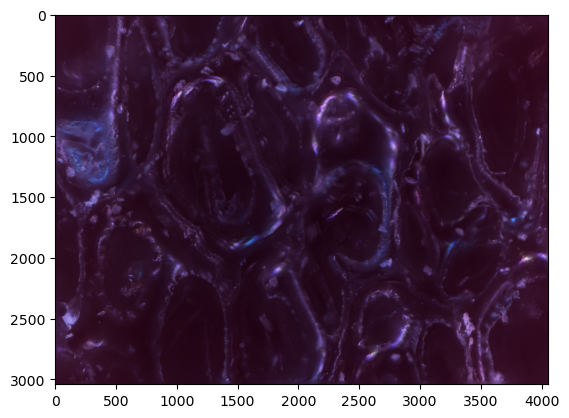

In [ ]:
plt.imshow(Image.open(os.path.join(img_dir,'preprocessed','hdr_result_2f.tiff')))


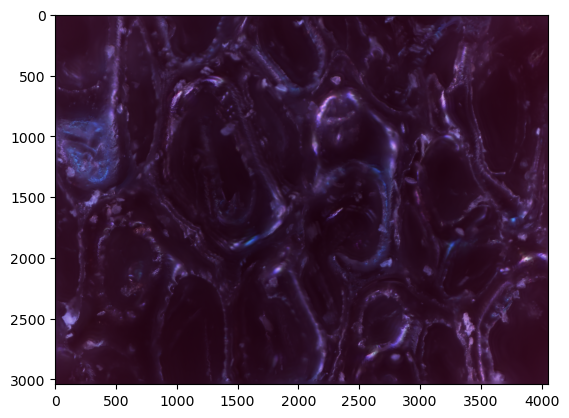

In [ ]:
plt.imshow(Image.open(os.path.join(img_dir,'preprocessed','hdr_result_f.tiff')))